In [1]:
from scipy import fft
import numpy as np
import operator
import imageio as im
from functools import reduce
from itertools import repeat, starmap
import matplotlib.pyplot as plt
import numpy.lib.stride_tricks as strides
import os

In [2]:
def calculate_bounding_shape(arrays):
    shapes = map(np.shape, arrays)
    dimension_sizes = zip(*shapes)
    return tuple(map(max, dimension_sizes))

def pad_symmetrically_to_shape(arr, shape):
    differences = map(lambda x: operator.sub(*x), zip(shape, arr.shape))
    paddings = tuple(map(lambda x: (x // 2, int(np.ceil(x / 2))), differences))
    return np.pad(arr, paddings)

def pad_symmetrically_to_same_shape(arrays):
    target_shape = calculate_bounding_shape(arrays)
    equalize_shapes = lambda arr: pad_symmetrically_to_shape(arr, target_shape)
    return list(map(equalize_shapes, arrays))

def apply_on_freq_domain(function, *args):
    frequencies = fft.rfftn(pad_symmetrically_to_same_shape(args))
    return fft.fftshift(fft.irfftn(function(*frequencies)))

In [3]:
def scale_intensities(img, new_min=0, new_max=255):
    """
    Normalizes the image img to the range [new_min, new_max]. This is done by
    applying to all pixels p a funciton f(p) = ap + b such that for img.max(),
    f(img.max()) = new_max and for img.min(), f(img.min()) = new_min.
    """
    img_min = np.min(img, axis=(0,1))
    img_max = np.max(img, axis=(0,1))
    a = (new_max - new_min) / (img_max - img_min)
    b = new_min - img_min * a
    return a * img + b

def rgb_to_monochromatic(img):
    weights = np.array([0.144, 0.299, 0.587])
    return img @ weights

def ensure_divisability(img, factor):
    a = img.shape[0] % factor
    rows = img if a == 0 else img[a // 2:-int(np.ceil(a / 2))]
    b = img.shape[1] % factor
    return rows if b == 0 else rows[:,b // 2:-int(np.ceil(b / 2))]

def calculate_partitions_shape(img, n_rows, n_cols):
    h = img.shape[0] // n_rows
    w = img.shape[1] // n_cols
    return (h, w) if img.ndim == 2 else (h, w, 1)

def calculate_strides_shape(partitions_shape, n_rows, n_cols):
    shape = (n_rows, n_cols) if len(partitions_shape) < 3 else (n_rows, n_cols, 3)
    return (*shape, *partitions_shape)

def calculate_partition_strides(sliding_windows, partitions_shape):
    padding = (0, len(sliding_windows.strides) - 2)
    weights = np.pad((partitions_shape[:2]), padding, constant_values=1)
    return weights * sliding_windows.strides

def partition_image(img, n_rows, n_cols):
    partitions_shape = calculate_partitions_shape(img, n_rows, n_cols)
    sliding_windows = strides.sliding_window_view(img, partitions_shape)
    shape = calculate_strides_shape(partitions_shape, n_rows, n_cols)
    partition_strides = calculate_partition_strides(sliding_windows, partitions_shape)
    return strides.as_strided(sliding_windows, shape=shape, strides=partition_strides)

def downsample_img(img, factor):
    used_img = ensure_divisability(img, factor)
    n_rows = used_img.shape[0] // factor
    n_cols = used_img.shape[1] // factor
    partitions = partition_image(used_img, n_rows, n_cols)
    partitions_axis = (2,3) if img.ndim == 2 else (3, 4, 5)
    return np.median(partitions, axis=partitions_axis).astype(img.dtype)

def threshold(img, percentage):
    return (img > np.percentile(img, 100*percentage)).astype(int)

In [4]:
def split_rgb_channels(img):
    return np.squeeze(np.split(img, 3, axis=-1), axis=-1)

def cross_correlate(img, filt):
    return apply_on_freq_domain(lambda x,y: x*np.conj(y), img, filt)

def convolve(img, filt):
    return apply_on_freq_domain(np.multiply, img, filt)

def generate_zero_centered_arange(size):
    center = size // 2
    return np.arange(size) - center

def compute_2d_gaussian(x, y, sigma):
    if sigma == 0:
        return np.ones_like(x)
    return 1 / (2 * np.pi * sigma2) * np.exp(x2 + y2 / (2 * sigma2))

def ensure_is_odd(value):
    return value + (1 - value % 2)

def compute_optimal_gaussian_filter_size(sigma):
    return ensure_is_odd(int(2 * sigma))

def generate_gaussian_filter(sigma=1):
    if sigma == 0:
        return np.array([[1]])
    filter_size = compute_optimal_gaussian_filter_size(sigma)
    zcrange = generate_zero_centered_arange(filter_size)
    x, y = np.meshgrid(zcrange, zcrange)
    filt = np.exp(-(np.square(x) + np.square(y)) / (2 * np.square(sigma)))
    return filt / np.sum(filt)

from scipy.ndimage import convolve

def apply_gaussian_filter(img, sigma=1):
    gaussian = generate_gaussian_filter(sigma=sigma)
    if img.ndim == 2:
        return convolve(img, gaussian)
    else:
        result = map(lambda channel: convolve(channel, gaussian), split_rgb_channels(img))
    return np.stack(tuple(result), axis=-1).astype(img.dtype)

In [5]:
base_dir = './rotation_fixed_1/'
image_paths = sorted(os.listdir(base_dir))[1:]
images = [im.imread(f'{base_dir}{path}') for path in image_paths]

In [6]:
used_images = list(map(lambda img: rgb_to_monochromatic(apply_gaussian_filter(downsample_img(img, 6), 3)), images))

In [8]:
thresholded = list(map(lambda img: threshold(img, 0.70), used_images))

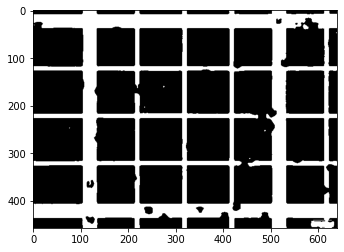

In [9]:
plt.imshow(thresholded[0], cmap='gray')

In [20]:
import re

def find_major_grid_lines(image, axis):
    is_line = np.sum(image, axis=1-axis) / image.shape[1 - axis] > 0.7
    splitted_chars = np.split(is_line.astype(int).astype(str), 2)
    joined_strs = list(map(lambda strings: ''.join(strings), splitted_chars))
    patterns = map(lambda s: max(re.findall(r'1+', s), key=len), joined_strs)
    idx1, idx2 = starmap(lambda p, s: s.find(p) + len(p) // 2, zip(patterns, joined_strs))
    return (idx1, idx2 + splitted_chars[0].shape[0])

In [21]:
def find_major_grid_corners(image):
    x_u, x_d = find_major_grid_lines(image, axis=0)
    y_l, y_r = find_major_grid_lines(image, axis=1)
    return np.array([
        [[x_u, y_l], [x_u, y_r]],
        [[x_d, y_l], [x_d, y_r]]
    ])

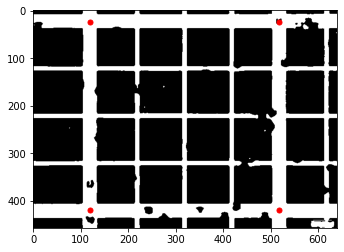

In [23]:
corners = np.vstack(find_major_grid_corners(thresholded[0]))
plt.imshow(thresholded[0], cmap='gray')
x, y = zip(*corners)
plt.plot(y, x, color='red', marker='o', linestyle='None', markersize=5)